Class imbalance exists so SMOTE is applied to remove it

In [ ]:
import os
import shutil
from random import shuffle
import cv2
import numpy as np
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

%matplotlib inline

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
np.warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
drive_path = "/content/drive/MyDrive/ML Project"
training_file_path = os.path.join(drive_path,'Data Files/training_data.npy')
training_full_file_path = os.path.join(drive_path,'Data Files/training_full_data.npy')
testing_file_path = os.path.join(drive_path,'Data Files/testing_data.npy')

In [ ]:
training_data = []
training_data = np.load(training_file_path,allow_pickle=True)
testing_data = []
testing_data = np.load(testing_file_path,allow_pickle=True)
print(f"Training samples count: {len(training_data)}")
print(f"Testing samples count: {len(testing_data)}")

Training samples count: 1500
Testing samples count: 210


In [ ]:
full_training_data = np.load(training_full_file_path,allow_pickle=True)
print(f"Training samples count: {len(full_training_data)}")

Training samples count: 1997


In [ ]:
label = [1, 0] # [normal,covid positive]

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

In [ ]:
X_train = [ x[0] for x in full_training_data]
Y_train = [ x[1] for x in full_training_data]

In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [ ]:
Y_train.shape

(1997, 2)

In [ ]:
def remove_text(img,demo):
    '''
    Attempts to remove bright textual artifacts from X-ray images. For example, many images indicate the right side of
    the body with a white 'R'. Works only for very bright text.
    :param img: Numpy array of image
    :return: Array of image with (ideally) any characters removed and inpainted
    '''
    mask = cv2.threshold(img, 225, 255, cv2.THRESH_BINARY)[1][:,:].astype(np.uint8)
    img = img.astype(np.uint8)
    result = cv2.inpaint(img, mask, 20, cv2.INPAINT_NS).astype(np.float32)

    if demo == 1:
                
      fig = plt.figure(figsize=(10,10))    
    
      plt.subplot(2, 3, 1)
      plt.imshow(img, cmap='gray')
      plt.title("Original CXR")

      plt.subplot(2, 3, 2)
      plt.imshow(mask,cmap='gray')
      plt.title("Mask")

      plt.subplot(2, 3, 3)
      plt.imshow(result,cmap='gray')
      plt.title("Inpainted CXR")

    return result
   

In [ ]:
def remove_minibatch_text(images):
  minibatch = []

  for image in images:
    result = remove_text(image,0)
    minibatch.append(result)
  
  minibatch = np.array(minibatch)

  return minibatch


In [ ]:
batch = remove_minibatch_text(X_train[:20])
print(f"Batch shape: {batch.shape}")

Batch shape: (20, 256, 256)


In [ ]:
minibatch_size = 64
minibatches = round(len(Y_train) / minibatch_size)
img_size = 256
start = 0
end = minibatch_size

In [ ]:
print(f"No of minibatches: {minibatches}")
print(f"No of X samples before smote: {len(X_train)}")
print(f"No of Y samples before smote: {len(Y_train)}")

print("Shape of X and Y samples:")
print(X_train.shape)
print(Y_train.shape)

No of minibatches: 31
No of X samples before smote: 1997
No of Y samples before smote: 1997
Shape of X and Y samples:
(1997, 256, 256)
(1997, 2)


In [ ]:
X_train_final = np.array([X_train[0]])
Y_train_final = np.array([Y_train[0]])

for _ in tqdm(range(minibatches), total=minibatches):

  X_mini_batch = X_train[start:end]
  #print(X_mini_batch.shape)
  X_mini_batch = remove_minibatch_text(X_mini_batch)
  #print(X_mini_batch.shape)
  size, w, h = X_mini_batch.shape
  X_mini_batch = X_mini_batch.reshape(size,w*h)

  Y_mini_batch = Y_train[start:end]
  #print(Y_mini_batch.shape)
  X_smote, Y_smote = sm.fit_resample(X_mini_batch,Y_mini_batch)

  size, _= X_smote.shape
  X_smote = X_smote.reshape(size,img_size,img_size)
  
  X_train_final = np.concatenate((X_train_final,X_smote),axis=0)
  
  for y in Y_smote:
    if y==1:
      Y_train_final = np.append(Y_train_final,np.array([[1,0]]),axis=0)
    else:
      Y_train_final = np.append(Y_train_final,np.array([[0,1]]),axis=0)
  
  start = end
  end += minibatch_size



100%|██████████| 31/31 [01:28<00:00,  2.84s/it]


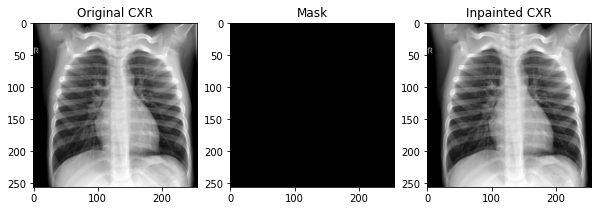

In [ ]:
image = remove_text(X_train_final[10],1)

After SMOTE

In [ ]:
print(f"No of X samples after smote: {len(X_train_final)}")

print(f"No of Y samples after smote: {len(Y_train_final)}")

print("Number of samples of Normal and Covid positive ")
print(np.sum(Y_train_final,axis=0))

print("Both became equal which removes the class imabalance problem")

No of X samples before smote: 2775
No of Y samples before smote: 2775
Number of samples of Normal and Covid positive 
[1388 1387]
Both became equal which removes the class imabalance problem


In [ ]:
smoted_training_data = []

for x,y in zip(X_train_final,Y_train_final):
  smoted_training_data.append([np.array(x),np.array(y)])
  

In [ ]:
len(smoted_training_data)

2775

In [ ]:
smote_training_file_path = os.path.join(drive_path,'Data Files/training_smote_data.npy')
np.save(smote_training_file_path,smoted_training_data)

In [ ]:
full_training_data = np.load(smote_training_file_path,allow_pickle=True)
print(f"Training samples count: {len(full_training_data)}   [Before - 1500]")
print("85% training data has been increased using SMOTE")

Training samples count: 2775   [Before - 1500]
85% training data has been increased using SMOTE


In [ ]:
full_training_data.shape

(2775, 2)

In [ ]:
print(f"Shape of X: {full_training_data[0][0].shape}")
print(f"Shape of Y: {full_training_data[0,1].shape}")

Shape of X: (256, 256)
Shape of Y: (2,)


In [ ]:
print("[Normal Covid+]")
print(np.sum(full_training_data[:,1],axis=0))

[Normal Covid+]
[1388 1387]


Coverting all images from 1 channel (grayscale) to 3 channel RGB

Just preparing this data so that we can make model that works on 3 channel image data.

In [ ]:
from PIL import Image
smote_training_file_path = os.path.join(drive_path,'Data Files/training_smote_data.npy')

In [ ]:
smoted_training_data = np.load(smote_training_file_path,allow_pickle=True)
print(f"Training samples count: {len(smoted_training_data)}")

Training samples count: 2775


In [ ]:
print(np.sum(smoted_training_data[:,1],axis=0))

[1388 1387]


In [ ]:
smoted_training_data[0][0].shape

(256, 256)

(256, 256)
F


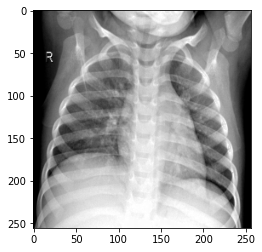

In [ ]:
data=smoted_training_data[1][0]
print(data.shape)
img=Image.fromarray(data)
print(img.mode)
plt.imshow(data, cmap="gray")

👆 See this image is F that means its in grayscale so only 1 channel is there.

In [ ]:
RGB_smoted_train_data = []
for i,(x,y) in enumerate(smoted_training_data):
  new_x = np.array(cv2.cvtColor(x,cv2.COLOR_GRAY2RGB), np.uint8)
  new_y = np.array(smoted_training_data[i][1].reshape(1,2))
  RGB_smoted_train_data.append([new_x,new_y])

RGB


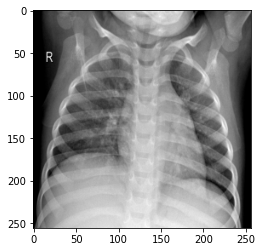

In [ ]:
img = RGB_smoted_train_data[0][0]
#img = img.astype(np.uint8)
img=Image.fromarray(img)
print(img.mode)
plt.imshow(img)

In [ ]:
RGB_smoted_train_data[0]

[array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [105, 105, 105],
         [119, 119, 119],
         [139, 139, 139]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [113, 113, 113],
         [131, 131, 131],
         [144, 144, 144]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [126, 126, 126],
         [143, 143, 143],
         [130, 130, 130]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [ 27,  27,  27],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [ 44,  44,  44],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  2,   2,   2],
         [ 59,  59,  59],
         ...,
         [  0,   0,   0],
  

In [ ]:
from random import shuffle
RGB_training_file_path = os.path.join(drive_path,'Data Files/training_RGB_data.npy')

In [ ]:
shuffle(RGB_smoted_train_data)

In [ ]:
np.save(RGB_training_file_path,RGB_smoted_train_data)
# training file saved

Will do the same with test data too

In [ ]:
testing_data_path  = '/content/drive/MyDrive/ML Project/Data Files/testing_data.npy'
testing_data = np.load(testing_data_path, allow_pickle=True) 

In [ ]:
np.sum(testing_data[:,1],axis=0)

array([148,  62])

In [ ]:
RGB_testing_data = []
for i,(x,y) in enumerate(testing_data):
  new_x = np.array(cv2.cvtColor(x,cv2.COLOR_GRAY2RGB), np.uint8)
  new_y = np.array(testing_data[i][1].reshape(1,2))
  RGB_testing_data.append([new_x,new_y])


In [ ]:
RGB_testing_file_path = os.path.join(drive_path,'Data Files/testing_RGB_data.npy')
shuffle(RGB_testing_data)

In [ ]:
np.save(RGB_testing_file_path,RGB_testing_data)

Test the newly created files

In [ ]:
train = np.load(RGB_training_file_path, allow_pickle=True) 
test = np.load(RGB_testing_file_path, allow_pickle=True) 

print(f"Shape of train data: {train.shape}")
print(f"Shape of test data: {test.shape}")

Shape of train data: (2775, 2)
Shape of test data: (210, 2)


In [ ]:
np.sum(train[:,1],axis=0)

array([1388, 1387])

In [ ]:
np.sum(test[:,1],axis=0)

array([[148,  62]])

In [ ]:
print(f"Shape of Train X samples: {train[0][0].shape}")
print(f"Shape of Train Y samples: {train[0][1].shape}")
print(f"Shape of Test X samples: {test[0][0].shape}")
print(f"Shape of Test Y samples: {test[0][1].shape}")
print("Successfully converted into RGB(3) channel image data")

Shape of Train X samples: (256, 256, 3)
Shape of Train Y samples: (2,)
Shape of Test X samples: (256, 256, 3)
Shape of Test Y samples: (1, 2)
Successfully converted into RGB(3) channel image data


In [ ]:
img_train = Image.fromarray(train[0][0])
print(f"Mode of train image: {img_train.mode}")
img_test = Image.fromarray(test[0][0])
print(f"Mode of test image: {img_test.mode}")

Mode of train image: RGB
Mode of test image: RGB


Final stats on our dataset

In [ ]:
drive_path = "/content/drive/MyDrive/ML Project"
RGB_training_file_path = os.path.join(drive_path,'Data Files/training_RGB_data.npy')
RGB_testing_file_path = os.path.join(drive_path,'Data Files/testing_RGB_data.npy')

train_data = np.load(RGB_training_file_path, allow_pickle=True) 
test_data = np.load(RGB_testing_file_path, allow_pickle=True) 


In [ ]:
train_normal, train_covid = np.sum(train_data[:,1],axis=0)[0]
test_normal, test_covid = np.sum(test_data[:,1],axis=0)[0]

In [ ]:
total = train_normal + train_covid
total += test_normal + test_covid

print(f"No. of Training Covid samples: {train_covid}")
print(f"No. of Training Normal samples: {train_normal}")
print(f"No. of Testing Covid samples: {test_covid}")
print(f"No. of Testing Normal samples: {test_normal}")
print(f"Total count of samples: {total}")

No. of Training Covid samples: 1387
No. of Training Normal samples: 1388
No. of Testing Covid samples: 62
No. of Testing Normal samples: 148
Total count of samples: 2985


In [2]:
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/ML Project/SMOTE preprocessing.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/ML Project/SMOTE preprocessing.ipynb to html
[NbConvertApp] Writing 517679 bytes to /content/drive/MyDrive/ML Project/SMOTE preprocessing.html
